Generative adversarial networks can be used to generate more data examples, augmentate existing data, find anomalies etc. Helpful, when large class inbalance or few anomalies. This notebook works on code level, but for better quality results Perceptual loss, WGAN etc. advanced methods would need to be implemented.

## Data processing

### Loading libraries and defining functions

In [38]:
import numpy as np
import os
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Lambda, Flatten, Reshape, Conv2DTranspose, Dropout, BatchNormalization, LeakyReLU, Activation, concatenate, Multiply, Add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
import keras
from keras.metrics import binary_crossentropy 
from keras import backend as K
from skimage.metrics import structural_similarity as ssim
from skimage import exposure
from sklearn.model_selection import train_test_split
from keras.regularizers import l1, l2
from tensorflow.keras.losses import MeanSquaredError
from scipy.linalg import sqrtm
from tensorflow.image import resize, grayscale_to_rgb

"""Different types of normalizers for variable data shapes, including data with very small (-1e+30) NaN values"""

def normalize_tile_z(tile):
    """Normalize the tile using its mean and standard deviation."""
    mean = np.nanmean(tile)
    std = np.nanstd(tile)
    
    # Return the standardized tile
    return (tile - mean) / (std + 1e-7)

def normalize_tile_one(tile):
    valid_mask = ~np.isnan(tile)
    
    # Check if there's any valid data in the tile
    if np.any(valid_mask):
        min_val = np.min(tile[valid_mask])
        max_val = np.max(tile[valid_mask])
        
        if max_val != min_val:
            tile[valid_mask] = (tile[valid_mask] - min_val) / (max_val - min_val)
        else:
            tile[valid_mask] = 0.0  # If max equals min, set to 0
    return tile

def normalize_tile_adaptive(tile, method="minmax"):
    if method == "standard":
        mean = np.nanmean(tile)
        std = np.nanstd(tile)
        return (tile - mean) / (std + 1e-7)
    elif method == "minmax":
        min_val = np.nanmin(tile)
        max_val = np.nanmax(tile)
        return (tile - min_val) / (max_val - min_val)

def normalize_tile_clipping(tile):
    """Normalize the tile using its mean and standard deviation."""
    # Clip the tile values
    lower_threshold = np.nanpercentile(tile, 1)
    upper_threshold = np.nanpercentile(tile, 99)
    tile = np.clip(tile, lower_threshold, upper_threshold)
    
    # Normalize the tile
    mean = np.nanmean(tile)
    std = np.nanstd(tile)
    
    return (tile - mean) / (std + 1e-7)

def normalize_tile_clipping_255(tile):
    """Normalize the tile using its mean and standard deviation and clip it based on the range [mean-2*std, mean+2*std]."""

    mean_tile = np.nanmean(tile)
    std_tile = np.nanstd(tile)

    # Clipping the tile based on the standard deviation and mean
    np.clip(tile, mean_tile - 2 * std_tile, mean_tile + 2 * std_tile, out=tile)

    # Normalize to 0-255
    tile = ((tile - np.nanmin(tile)) / (np.nanmax(tile) - np.nanmin(tile))) * 255

    return tile.astype(np.uint8)

def adaptive_clip_and_scale(tile, factor=2):
    """
    Perform adaptive clipping and scaling of the tile.

    Parameters:
    - tile: The image tile to be processed.
    - factor: Multiplier for std deviation to compute clipping bounds.

    Returns:
    - Processed tile with values between 0 and 255.
    """
    
    # If the tile consists only of NaNs, return an all-zero tile.
    if np.all(np.isnan(tile)):
        return np.zeros_like(tile, dtype=np.uint8)

    # Calculate local statistics
    mean = np.nanmean(tile)
    std = np.nanstd(tile)

    # Check if the standard deviation is 0, if so return a tile filled with mean value scaled to [0,255]
    if std == 0:
        scaled_mean = ((mean - np.nanmin(tile)) / (np.nanmax(tile) - np.nanmin(tile)) * 255).astype(np.uint8)
        return np.full_like(tile, scaled_mean, dtype=np.uint8)

    # Define bounds for clipping
    lower_bound = mean - factor * std
    upper_bound = mean + factor * std

    # Clip values
    tile_clipped = np.clip(tile, lower_bound, upper_bound)

    # Scale values to [0, 255]
    min_val = np.min(tile_clipped)
    max_val = np.max(tile_clipped)
    
    # Check if after clipping, max is less than or equal to min
    if max_val <= min_val:
        return np.full_like(tile, 127, dtype=np.uint8)  # Return a gray tile

    tile_scaled_0_1 = (tile_clipped - min_val) / (max_val - min_val)
    tile_scaled_0_255 = (tile_scaled_0_1 * 255).astype(np.uint8)

    return tile_scaled_0_255

def clip_and_scale(tile, global_mean, global_std, factor=2):
    """
    Perform clipping based on global statistics and scale the tile.

    Parameters:
    - tile: The image tile to be processed.
    - global_mean: Mean of the entire dataset.
    - global_std: Standard deviation of the entire dataset.
    - factor: Multiplier for std deviation to compute clipping bounds.

    Returns:
    - Processed tile with values between 0 and 255.
    """
    
    # Define bounds for clipping based on global statistics
    lower_bound = global_mean - factor * global_std
    upper_bound = global_mean + factor * global_std

    # Clip values
    tile_clipped = np.clip(tile, lower_bound, upper_bound)

    # Scale values to [0, 255]
    min_val = np.min(tile_clipped)
    max_val = np.max(tile_clipped)
    
    if max_val <= min_val:
        return np.full_like(tile, 127, dtype=np.uint8)  # Return a gray tile

    tile_scaled_0_1 = (tile_clipped - min_val) / (max_val - min_val)
    tile_scaled_0_255 = (tile_scaled_0_1 * 255).astype(np.uint8)

    return tile_scaled_0_255
    
# Loading and Preprocessing Images

def extract_tiles(img, tile_size):
    images_list = []

    # Calculate the number of tiles needed in both dimensions
    n_tiles_x = img.shape[0] // tile_size
    n_tiles_y = img.shape[1] // tile_size

    # Pad the image if necessary to extract tiles
    pad_width_x = tile_size - (img.shape[0] % tile_size) if img.shape[0] % tile_size != 0 else 0
    pad_width_y = tile_size - (img.shape[1] % tile_size) if img.shape[1] % tile_size != 0 else 0

    img = np.pad(img, ((0, pad_width_x), (0, pad_width_y)), mode='constant')

    for i in range(0, img.shape[0], tile_size):
        for j in range(0, img.shape[1], tile_size):
            tile = img[i:i+tile_size, j:j+tile_size]
            images_list.append(tile)

    return np.array(images_list)


def load_and_tile_images_from_folder(folder_path, tile_size=64):
    images_list = []
    for filename in sorted(os.listdir(folder_path)):  # Sorting ensures images from different folders align properly
        if filename.endswith('.tif'):
            img = imread(os.path.join(folder_path, filename))
            
            images_list.extend(extract_tiles(img, tile_size))

            """for img in images_list:  # inspect the images
                print(img.shape)"""
    
    return np.stack(images_list, axis=0) #np.array(images_list)

# Data Augmentation

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

datagen_adjuste = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0,
    brightness_range=[0.5, 1.5],  # adjust brightness
    channel_shift_range=0.2  # shift channel values
)

def augment_images_together(*image_batches):
    # Assuming all image_batches are of the same length, 
    # and images in position i of each batch correspond to each other
    augmented_batches = [[] for _ in range(len(image_batches))]
    
    for i in range(len(image_batches[0])):
        combined_image = np.stack([image_batches[j][i] for j in range(len(image_batches))], axis=-1)  # stack along the channel dimension
        augmentation_iterator = datagen.flow(np.expand_dims(combined_image, axis=0), batch_size=1)
        augmented_image = augmentation_iterator[0].squeeze(axis=0)
        
        for j in range(len(image_batches)):
            augmented_batches[j].append(augmented_image[..., j])  # separate the channels
    
    return [np.array(batch) for batch in augmented_batches]

def handle_missing_values(images):
    """Handle NaN and extremely small values in the dataset."""
    
    # Check for NaN values
    has_nan = np.isnan(images).any()
    print(f"Dataset contains NaN values: {has_nan}")
    images[np.isnan(images)] = 0.0  # replace NaN with 0
    
    # Handle 'no-data' or extremely small values
    no_data_mask = images < -1e+29
    print(f"Number of 'no-data' values: {np.sum(no_data_mask)}")
    #images[no_data_mask] = 0.0
    
    mean_val = np.mean(images[~no_data_mask])
    images[no_data_mask] = mean_val
    
    return images

def replace_nans(image, value=0):
    """Replace NaN values in the image with the specified value."""
    nan_mask = np.isnan(image)
    image[nan_mask] = value
    return image

def replace_nans_with_mean(image):
    """Replace NaN values in the image with the mean of the non-NaN values."""
    nan_mask = np.isnan(image)
    image[nan_mask] = np.nanmean(image)
    return image

def handle_nans_and_infs(image):
    """Replace NaN and Inf values in an image."""
    non_finite_mask = ~np.isfinite(image)  # True for NaN and Inf values
    mean_val = np.mean(image[np.isfinite(image)])  # mean of finite values
    image[non_finite_mask] = mean_val
    return image

def normalize_images_old(images):
    return images.astype('float32') / 255.0

def remove_nan(img_np):
    # handle null values
    img_np[img_np < -1e+30] = np.nan 

    return img_np

# To avoid division by zero error, when max_val == min_val
def normalize_tile(tile):
    min_val = np.min(tile)
    max_val = np.max(tile)
    if max_val != min_val:
        tile = ((tile - min_val) / (max_val - min_val)) * 255
    else:
        tile = np.zeros_like(tile)

    return tile

def equalize_images(images):
    return exposure.equalize_hist(images) * 255

def contrast_stretching(image, new_min=0, new_max=1):
    """Perform contrast stretching on the given image."""
    return (image - np.min(image)) / (np.max(image) - np.min(image)) * (new_max - new_min) + new_min

def contrast_stretching_consider_uniform_values(image, new_min=0, new_max=1, epsilon=1e-7):
    """Perform contrast stretching on the given image."""
    min_val = np.min(image)
    max_val = np.max(image)

    # Check if the max and min values are very close or identical
    if np.isclose(max_val, min_val, atol=epsilon):
        return np.ones_like(image) * new_min  # or any other default behavior

    return (image - min_val) / (max_val - min_val + epsilon) * (new_max - new_min) + new_min


def apply_preprocessing(images_list):
    """Apply preprocessing techniques to a list of images."""
    processed_images = []
    
    for image in images_list:
        # Handle NaN values
        image = handle_nans_and_infs(image)
        
        # Apply contrast stretching
        #stretched_image = contrast_stretching(image)
        image = contrast_stretching_consider_uniform_values(image)
        
        # Apply histogram equalization
        equalized_image = exposure.equalize_hist(image) * 255
        
        processed_images.append(equalized_image)
    
    return processed_images

def normalize_images(images):
    min_val = np.min(images)
    max_val = np.max(images)
    return (images - min_val) / (max_val - min_val)

# A datagenerator with default values set
def create_datagenerator(rotation_range=20, width_shift_range=0.1, eight_shift_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='constant', cval=0,brightness_range=[0.5, 1.5], channel_shift_range=0.2):
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode=fill_mode,
        cval=cval,
        brightness_range=brightness_range,  # adjust brightness
        channel_shift_range=channel_shift_range  # shift channel values
    )
    
    return datagen

def augment_image_dataset(image_list, augment_times=5):
    # Initialize the ImageDataGenerator with the desired augmentations
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0
    )

    datagen_adjusted = ImageDataGenerator(
        rotation_range=20,
        #width_shift_range=0.1,
        #height_shift_range=0.1,
        #zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0,
        brightness_range=[0.5, 1.5],  # adjust brightness
        channel_shift_range=0.2  # shift channel values
    )
    
    augmented_images = []

    for image in image_list:
        #augmentation_iterator = datagen.flow(np.expand_dims(image, axis=0), batch_size=1)
        augmentation_iterator = datagen_adjusted.flow(np.expand_dims(image, axis=0), batch_size=1)
        
        for j in range(augment_times):
            augmented_images.append(augmentation_iterator[0].squeeze(axis=0))

    return np.array(augmented_images)

# Clip the dataset length to the shortest dataset (recommended to use data augmentation first to not lose data)
def prepare_multimodal_dataset(augmented_AEM_images, augmented_Gravity_images, augmented_Radiometric_images, augmented_Magnetic_images):
    # Find the smallest length
    min_length = min([len(x) for x in [augmented_AEM_images, augmented_Gravity_images, augmented_Radiometric_images, augmented_Magnetic_images]])
    
    # Trim datasets to match the smallest length
    x1_trimmed = augmented_AEM_images[:min_length]
    x2_trimmed = augmented_Gravity_images[:min_length]
    x3_trimmed = augmented_Radiometric_images[:min_length]
    x4_trimmed = augmented_Magnetic_images[:min_length]
    
    combined_data = np.stack((x1_trimmed, x2_trimmed, x3_trimmed, x4_trimmed), axis=-1)

    return combined_data

# Delete failed augmentations or null images, that are extracted from the border of the original image
def delete_null_or_1_value_images(data, min_value=1):
    removed = 0
    indices_to_remove = [i for i in range(len(data)) if len(np.unique(data[i])) <= min_value]
    removed = len(indices_to_remove)
    X = np.delete(data, indices_to_remove, axis=0)

    print("Removed ", removed)    

    return X

### Load your data

Here, geophysical images were used (AEM, Gravity, Radiometric, Magnetic)

In [2]:
# Load all images from each category and stack them

#AEM_folder = ...
#Gravity_folder = ...
#Radiometric_folder = ...
#Magnetic_folder = ...

AEM_images = load_and_tile_images_from_folder(AEM_folder, 256)
Gravity_images = load_and_tile_images_from_folder(Gravity_folder, 256)
Radiometric_images = load_and_tile_images_from_folder(Radiometric_folder, 256)
Magnetic_images = load_and_tile_images_from_folder(Magnetic_folder, 256)

augmented_AEM_images, augmented_Gravity_images, augmented_Radiometric_images, augmented_Magnetic_images = AEM_images, Gravity_images, Radiometric_images, Magnetic_images

print(augmented_AEM_images.shape)
print(augmented_Gravity_images.shape)
print(augmented_Radiometric_images.shape)
print(augmented_Magnetic_images.shape)

augmented_AEM_images = handle_missing_values(augmented_AEM_images)
augmented_Gravity_images = handle_missing_values(augmented_Gravity_images)
augmented_Radiometric_images = handle_missing_values(augmented_Radiometric_images)
augmented_Magnetic_images = handle_missing_values(augmented_Magnetic_images)

augmented_AEM_images = apply_preprocessing(augmented_AEM_images)
augmented_Gravity_images = apply_preprocessing(augmented_Gravity_images)
augmented_Radiometric_images = apply_preprocessing(augmented_Radiometric_images)
augmented_Magnetic_images = apply_preprocessing(augmented_Magnetic_images)

(168, 256, 256)
(714, 256, 256)
(168, 256, 256)
(504, 256, 256)
Dataset contains NaN values: False
Number of 'no-data' values: 1171204
Dataset contains NaN values: False
Number of 'no-data' values: 6623948
Dataset contains NaN values: False
Number of 'no-data' values: 0
Dataset contains NaN values: False
Number of 'no-data' values: 391198


In [27]:
"""Check data range"""

def process_for_training(input, split_size):
    images = np.array(input)
    images = images.astype('float32') / 255.
    x_train, x_test = train_test_split(images, test_size=1-split_size)

    return x_train, x_test

data = np.array(augmented_Radiometric_images)
data = data.reshape(-1, 256, 256, 1)

data = delete_null_or_1_value_images(data, 3)

data = augment_image_dataset(data, 3)

data = delete_null_or_1_value_images(data, 3)

x_train, x_test = process_for_training(data, 0.95)

datasets = [x_train]#, x_test]
dataset_names = ["x_train", "x_test"]

for d, name in zip(datasets, dataset_names):
    min_val = np.min(d)
    max_val = np.max(d)
    print(f"Range for {name}: {min_val}, {max_val}")

Removed  96
Removed  0
Range for x_train: 0.0, 1.0


### Visualize images

(205, 256, 256, 1) (11, 256, 256, 1)


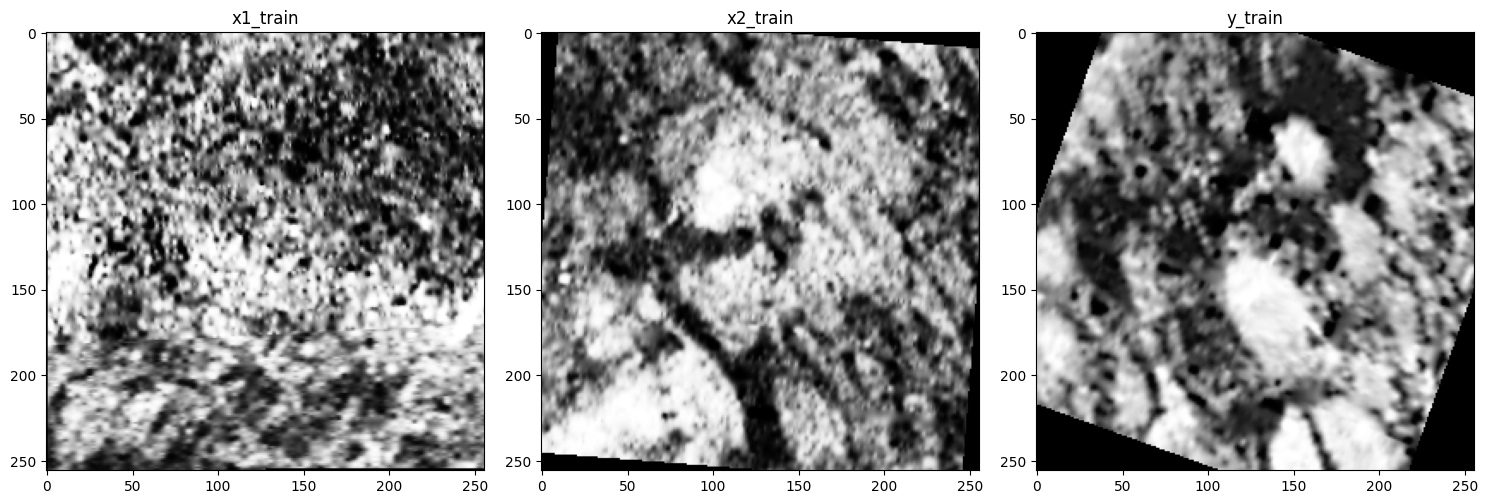

In [28]:
print(x_train.shape, x_test.shape)

# Visualize the images side by side

plt.figure(figsize=(15, 5))

j = 15

plt.subplot(1, 3, 1)
plt.imshow(x_train[j], cmap='gray')
plt.title('x1_train')

plt.subplot(1, 3, 2)
plt.imshow(x_train[j+1, :, :], cmap='gray')
plt.title('x2_train')

plt.subplot(1, 3, 3)
plt.imshow(x_train[j+2, :, :], cmap='gray')
plt.title('y_train')

plt.tight_layout()
plt.show()

Min: 0.0
Max: 0.9098039
Mean: 0.42763305
Standard Deviation: 0.27902043


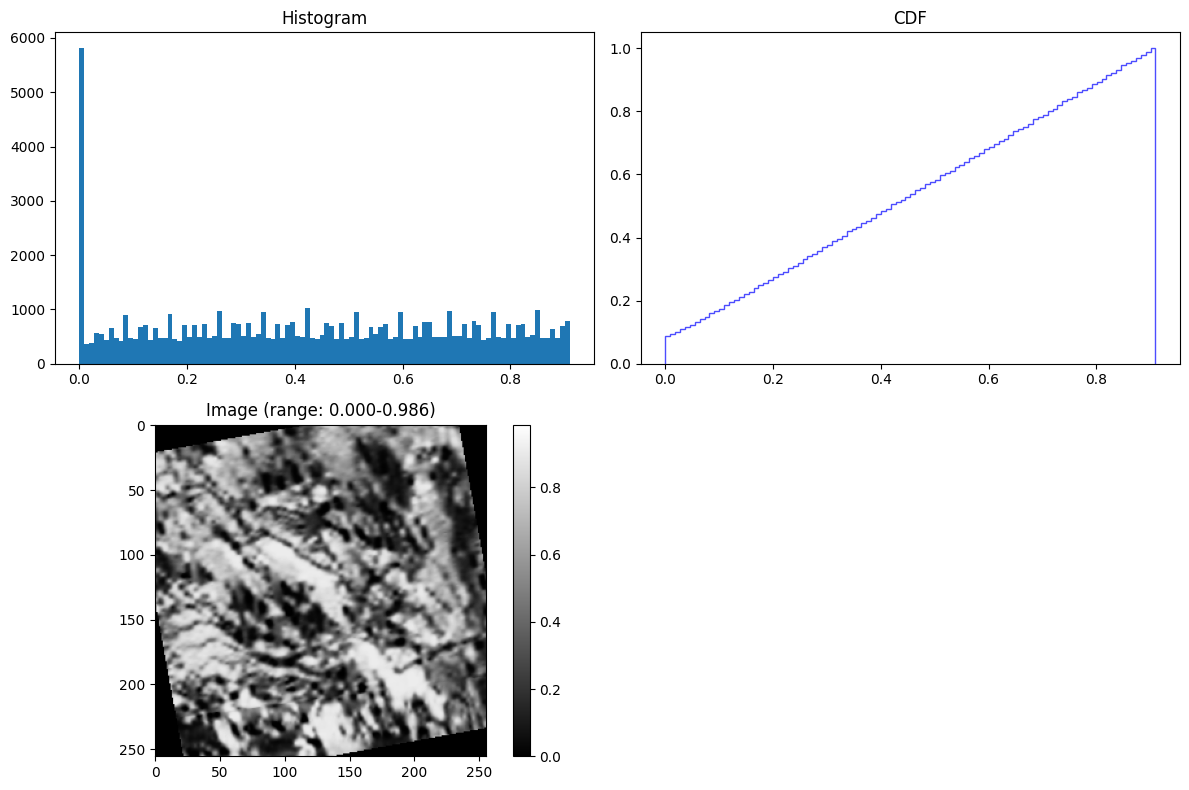

In [5]:
def visualize_image(img_data):
    # Load the image using raster.io
    """with rasterio.open(image_path, 'r') as src:
        img_data = src.read(1)"""
    
    # Print basic statistics
    print("Min:", np.nanmin(img_data))
    print("Max:", np.nanmax(img_data))
    print("Mean:", np.nanmean(img_data))
    print("Standard Deviation:", np.nanstd(img_data))
    
    valid_data = img_data[~np.isnan(img_data)]
    
    # Plot the histogram
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.hist(valid_data.ravel(), bins=100)
    plt.title("Histogram")
    
    # Plot the CDF
    plt.subplot(2, 2, 2)
    plt.hist(valid_data.ravel(), bins=100, cumulative=True, density=True, histtype='step', color='blue', alpha=0.7)
    plt.title("CDF")
    
    # Plot the image using mean±2 standard deviations as the display range
    plt.subplot(2, 2, 3)
    vmin = max(0, np.nanmean(img_data) - 2*np.nanstd(img_data))
    vmax = min(1, np.nanmean(img_data) + 2*np.nanstd(img_data))
    plt.imshow(img_data, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(f"Image (range: {vmin:.3f}-{vmax:.3f})")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

visualize_image(x_train[j])

## Generative adversarial network

In [6]:
def augment_image_dataset(image_list, augment_times=5):
    """
    Augment a list of images a specified number of times.

    Parameters:
    - image_list: A list of images to augment.
    - augment_times: How many augmented copies to produce for each input image.

    Returns:
    - A numpy array containing the augmented images.
    """
    
    # Initialize the ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0
    )

    augmented_images = []

    for image in image_list:
        augmentation_iterator = datagen.flow(np.expand_dims(image, axis=0), batch_size=1)
        
        for j in range(augment_times):
            augmented_images.append(augmentation_iterator[0].squeeze(axis=0))

    return np.array(augmented_images)

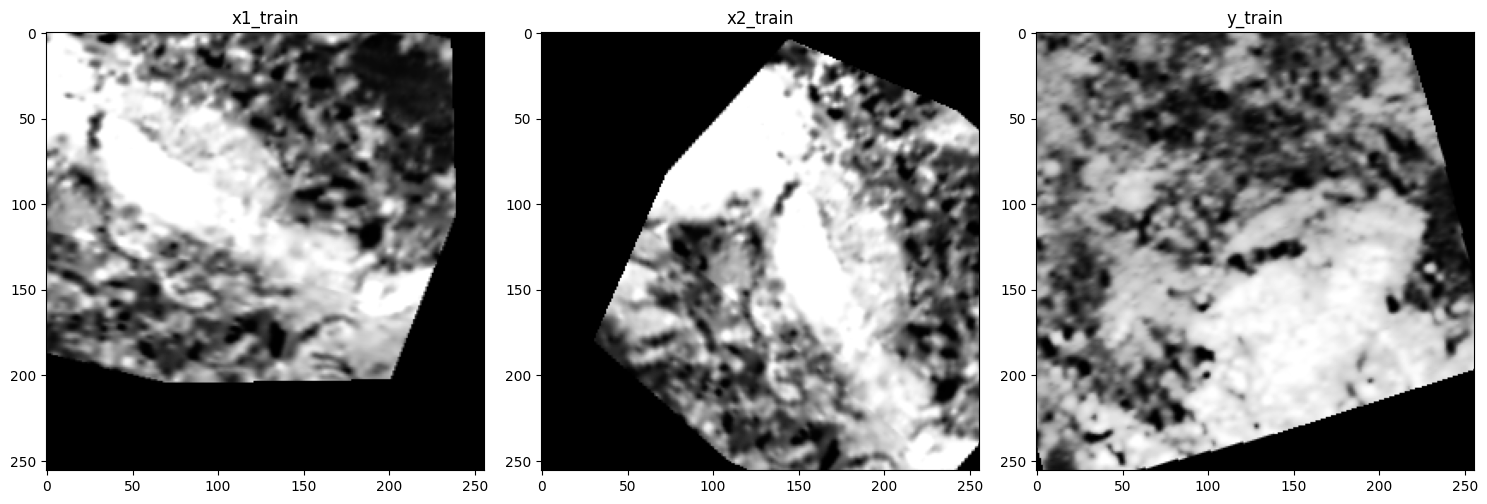

(615, 256, 256, 1)


In [7]:
# Visualize the images side by side

x_train = augment_image_dataset(x_train, 3)
x_test = augment_image_dataset(x_test, 3)

plt.figure(figsize=(15, 5))

j = 16

plt.subplot(1, 3, 1)
plt.imshow(x_train[j, :, :], cmap='gray')
plt.title('x1_train')

plt.subplot(1, 3, 2)
plt.imshow(x_train[j+1, :, :], cmap='gray')
plt.title('x2_train')

plt.subplot(1, 3, 3)
plt.imshow(x_train[j+2, :, :], cmap='gray')
plt.title('y_train')

plt.tight_layout()
plt.show()

print(x_train.shape)

In [8]:
"""Check data range"""

datasets = [x_train, x_test]
dataset_names = ["x_train", "x_test"]

for data, name in zip(datasets, dataset_names):
    min_val = np.min(data)
    max_val = np.max(data)
    print(f"Range for {name}: {min_val}, {max_val}")

Range for x_train: 0.0, 1.0
Range for x_test: 0.0, 1.0


In [9]:
def save_generated_samples(epoch, generator, noise_dim=100, num_samples=1, figsize=(1)):
    """Save generated samples as a grid image.
    
    Args:
    - epoch (int): Current epoch number, for filename.
    - generator (Model): Generator model.
    - noise_dim (int): Dimension of random noise vector.
    - num_samples (int): Number of samples to generate for grid.
    - figsize (tuple): Size of the full grid image.
    """
    
    # Generate random noise samples
    noise = np.random.normal(0, 1, (num_samples, noise_dim))
    
    # Generate images
    generated_imgs = generator.predict(noise)
    
    # Rescale images from [-1, 1] to [0, 1]
    #generated_imgs = 0.5 * generated_imgs + 0.5

    # Plot images in a grid
    fig, axs = plt.subplots(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), figsize=figsize)
    
    cnt = 0
    for i in range(int(np.sqrt(num_samples))):
        for j in range(int(np.sqrt(num_samples))):
            axs[i, j].imshow(generated_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
            
    # Save figure
    fig.savefig(f"gan_256_output_epoch_{epoch}.png")
    plt.close()

def add_label_noise(labels, noise_factor=0.05):
    """Adds random noise to the labels."""
    noise = tf.random.uniform(shape=labels.shape, minval=-noise_factor, maxval=noise_factor)
    return tf.clip_by_value(labels + noise, 0.0, 1.0)

def save_generated_samples_single(epoch, generator, noise_dim=100):
    """Save a single generated sample.
    
    Args:
    - epoch (int): Current epoch number, for filename.
    - generator (Model): Generator model.
    - noise_dim (int): Dimension of random noise vector.
    """
    
    # Generate random noise sample
    noise = np.random.normal(0, 1, (1, noise_dim))
    
    # Generate an image
    generated_img = generator.predict(noise)[0]
    
    # Rescale image from [-1, 1] to [0, 1] if needed
    # generated_img = 0.5 * generated_img + 0.5

    plt.imshow(generated_img[:, :, 0], cmap='gray')
    plt.axis('off')
    
    # Save figure
    plt.savefig(f"gan_256_output_single_epoch_{epoch}.png")
    plt.close()

### Basic GAN with modular size

In [23]:
def build_generator_modular(img_size=64, num_layers=2, dropout=0, regularization=0):
    noise_dim = 100
    initial_size = img_size // (2 ** num_layers)

    input_noise = Input(shape=(noise_dim,))
    x = Dense(256 * initial_size * initial_size)(input_noise)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((initial_size, initial_size, 256))(x)

    for i in range(num_layers):
        x = Conv2DTranspose(256 // (2 ** (i+1)), kernel_size=4, strides=2, padding="same", kernel_regularizer=l1(regularization))(x)
        x = Dropout(dropout)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation="sigmoid")(x)
    generator = Model(input_noise, x, name="generator_modular")
    
    return generator

def build_discriminator_modular(img_size=256, num_layers=4, dropout=0, regularization=0):
    input_img = Input(shape=(img_size, img_size, 1))
    x = input_img

    for i in range(num_layers):
        x = Conv2D(64 * (2 ** i), kernel_size=4, strides=2, padding="same", kernel_regularizer=l1(regularization))(x)
        x = Dropout(dropout)(x)
        x = LeakyReLU(alpha=0.2)(x)

        # Add BatchNormalization to all layers except the first one
        if i > 0:
            x = BatchNormalization()(x)

    # Flatten and apply sigmoid activation
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    discriminator = Model(input_img, x, name="discriminator_modular")

    return discriminator

# Compiling 
generator = build_generator_modular(img_size=256, num_layers=3)
discriminator = build_discriminator_modular(img_size=256, num_layers=3)

In [24]:
# Only compile the disc
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Make the discriminator non-trainable when we are training the generator
discriminator.trainable = False

print(generator.output_shape)
print(discriminator.input_shape)

# Create the combined model
noise = Input(shape=(100,))
generated_image = generator(noise)
validity = discriminator(generated_image)

combined = Model(inputs=noise, outputs=validity)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9
    return lr

lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.001)

combined.compile(optimizer=optimizer, loss='binary_crossentropy')

(None, 256, 256, 1)
(None, 256, 256, 1)


In [25]:
def add_label_noise(labels, noise_factor=0.05):
    """Adds random noise to the labels."""
    noise = tf.random.uniform(shape=labels.shape, minval=-noise_factor, maxval=noise_factor)
    return tf.clip_by_value(labels + noise, 0.0, 1.0)


def train_gan(generator, discriminator, combined, data, epochs, batch_size=128, save_interval=50):
    # Get the number of batches to cover all data
    num_batches = len(data) // batch_size

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # Shuffle data at the beginning of each epoch
        np.random.shuffle(data)

        for batch in range(num_batches):
            # Get the current batch of real images
            imgs = data[batch * batch_size: (batch + 1) * batch_size]

            # Generate batch of random noise inputs
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a batch of new images
            gen_imgs = generator.predict(noise)

            #  Train Discriminator

            # Train the discriminator
            real_loss = discriminator.train_on_batch(imgs, add_label_noise(valid))
            fake_loss = discriminator.train_on_batch(gen_imgs, add_label_noise(fake))
            d_loss = 0.5 * np.add(real_loss, fake_loss)

            #  Train Generator (multiple times for every discriminator training step)
            g_losses = []
            for _ in range(2):  # Train generator two times per discriminator step
                noise = np.random.normal(0, 1, (batch_size, 100))
                # Train the generator (to have the discriminator label samples as valid)
                g_loss = combined.train_on_batch(noise, valid)
                g_losses.append(g_loss)

            g_loss = np.mean(g_losses)

            # Save generated image samples at save_interval
            if epoch % save_interval == 0:
                save_generated_samples_single(epoch, generator)

        # Print progress
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]:.2f}%] [G loss: {g_loss}]")


train_gan(generator, discriminator, combined, x_train, epochs=200, batch_size=64, save_interval=5)

1/1 [==============================] - 0s 10ms/step
0/200 [D loss: 3.7718982696533203 | D accuracy: 42.97%] [G loss: 12.081825733184814]
2/2 [==============================] - 0s 23ms/step
1/200 [D loss: 3.8767969608306885 | D accuracy: 46.88%] [G loss: 0.0014727976522408426]
2/2 [==============================] - 0s 23ms/step
2/200 [D loss: 1.4660842418670654 | D accuracy: 47.66%] [G loss: 4.859987912109176e-09]
2/2 [==============================] - 0s 23ms/step
3/200 [D loss: 0.8065026104450226 | D accuracy: 57.03%] [G loss: 0.11535673588514328]
2/2 [==============================] - 0s 27ms/step
4/200 [D loss: 1.1653395891189575 | D accuracy: 50.78%] [G loss: 0.009438836947083473]
1/1 [==============================] - 0s 9ms/step
5/200 [D loss: 0.5855782628059387 | D accuracy: 50.00%] [G loss: 7.766478085646789e-11]
2/2 [==============================] - 0s 22ms/step
6/200 [D loss: 1.5265442728996277 | D accuracy: 49.22%] [G loss: 9.011206150054932]
2/2 [==========================

KeyboardInterrupt: 

In [ ]:
# Predict on noise and generate a visualizable sample

# Generate random noise samples
noise = np.random.normal(0, 1, (1, 100))

# Generate images
generated_imgs = generator.predict(noise)

# Rescale images from [-1, 1] to [0, 1]
# generated_imgs = 0.5 * generated_imgs + 0.5

generated_imgs = np.squeeze(generated_imgs, axis=0)

plt.imshow(generated_imgs, cmap='gray')
plt.colorbar()
plt.show()

print(np.max(generated_imgs))
print(np.min(generated_imgs))

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

def compute_fid(model, real_images, generated_images):
    """
    Compute FID score between real and generated images.
    
    Parameters:
    - model: The model (e.g., InceptionV3) to extract features
    - real_images: Numpy array of real images
    - generated_images: Numpy array of generated images
    
    Returns:
    - FID score
    """
    
    # Ensure the real and generated images have the same number of samples
    assert real_images.shape[0] == generated_images.shape[0], "Number of real and generated images should be the same."
    
    # Preprocess images for the chosen model
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)
    
    # Compute activations for real and generated images
    real_activations = model.predict(real_images)
    generated_activations = model.predict(generated_images)
    
    # Compute mean and covariance for real images
    mu_real = np.mean(real_activations, axis=0)
    sigma_real = np.cov(real_activations, rowvar=False)
    
    # Compute mean and covariance for generated images
    mu_gen = np.mean(generated_activations, axis=0)
    sigma_gen = np.cov(generated_activations, rowvar=False)
    
    # Compute sum of squared differences between means
    ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
    
    # Compute sqrt of product between covariances
    cov_mean = sqrtm(sigma_real.dot(sigma_gen))
    
    # Check for imaginary numbers in sqrt of product of covariances
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    
    # Compute FID score
    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * cov_mean)
    return fid

def grayscale_to_rgb(images):
    #Convert grayscale images to RGB by repeating the grayscale channel.
    return np.repeat(images, 3, axis=-1)


def generate_images(generator, num_images, noise_dim=100):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    generated_images = generator.predict(noise)
    return generated_images

def preprocess_images_for_inception(images):
    # Convert grayscale to RGB
    images_rgb = grayscale_to_rgb(images)
    # Resize images
    images_resized = resize(images_rgb, (299, 299))
    return images_resized

# Load the GAN's generator model
generator = generator

# Load InceptionV3 model without classification layer
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

num_images = 100  # number of images to evaluate with
generated_images = generate_images(generator, num_images)
generated_images = preprocess_images_for_inception(generated_images)

real_images = x_test[:num_images]
real_images = preprocess_images_for_inception(real_images)

fid_score = compute_fid(model, real_images, generated_images)
print(f"FID Score: {fid_score}")

In [ ]:
# Saving and loading the models

#generator.save(location...)
#discriminator.save(location...)

#loaded_generator = load_model('generator_model.h5', compile=True)
#loaded_discriminator = load_model('discriminator_model.h5', compile=True)

### Functions for perceptual loss (not used)

In [ ]:
# Extract features from autoencoder and CNN
def feature_extractor(model, layer_name):
    return Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

def perceptual_loss_autoencoder(autoencoder, layer_name):
    """
    Return a perceptual loss function based on the output of the layer_name in the autoencoder.
    """
    # Create a model that will return the activations of layer_name
    perceptual_model = Model(inputs=autoencoder.input,
                             outputs=autoencoder.get_layer(layer_name).output)
    mse = MeanSquaredError()
    
    def loss(y_true, y_pred):
        return mse(perceptual_model(y_true), perceptual_model(y_pred))
    
    return loss

# Compute perceptual loss
def perceptual_loss_autoencoder_and_cnn(y_true, y_pred):
    y_true_features_ae = encoder(y_true)
    y_pred_features_ae = encoder(y_pred)
    
    y_true_features_cnn = cnn_features(y_true)
    y_pred_features_cnn = cnn_features(y_pred)

    loss_ae = K.mean(K.square(y_true_features_ae - y_pred_features_ae))
    loss_cnn = K.mean(K.square(y_true_features_cnn - y_pred_features_cnn))
    
    # Weighted sum of the two losses. Weights can be adjusted if required.
    return 0.5 * loss_ae + 0.5 * loss_cnn

### Monolithic GANs

In [ ]:
# Generator
def build_generator():
    noise_dim = 100  # Size of the noise vector

    input_noise = Input(shape=(noise_dim,))
    x = Dense(128 * 64 * 64)(input_noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((64, 64, 128))(x)

    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation="tanh")(x)  # 3 channels

    generator = Model(input_noise, x, name="generator")
    return generator

# Discriminator
def build_discriminator():
    img_shape = (256, 256, 1)  # Input image shape

    input_img = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(input_img)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)

    discriminator = Model(input_img, x, name="discriminator")
    return discriminator

# Generator
def build_generator_drop_reg(dropout=0, regularization=0):
    noise_dim = 100  # Size of the noise vector

    input_noise = Input(shape=(noise_dim,))
    x = Dense(256 * 64 * 64)(input_noise)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((64, 64, 256))(x)


    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", kernel_regularizer=l1(regularization))(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", kernel_regularizer=l1(regularization))(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation="sigmoid")(x)  # 3 channels

    generator = Model(input_noise, x, name="generator")
    return generator

# Discriminator
def build_discriminator_drop_reg(dropout=0, regularization=0):
    img_shape = (256, 256, 1)  # Input image shape

    input_img = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", kernel_regularizer=l1(regularization))(input_img)
    x = Dropout(dropout)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_regularizer=l1(regularization))(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same", kernel_regularizer=l1(regularization))(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding="same", kernel_regularizer=l1(regularization))(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    discriminator = Model(input_img, x, name="discriminator")
    return discriminator          

## CNN for GAN's perceptual loss to replace VGG model / Fréchet (or Kernel) inception distance to replace Inception v3 model

In [12]:
# Generate labels
np_AEM = np.array(augmented_AEM_images)
np_Radio = np.array(augmented_Radiometric_images)

labels_class1 = np.zeros((np_AEM.shape[0], 1))
labels_class2 = np.ones((np_Radio.shape[0], 1))

# Concatenate data and labels
#all_images = tf.concat([augmented_AEM_images, augmented_Radiometric_images], axis=0)
#all_labels = tf.concat([labels_class1, labels_class2], axis=0)

X = np.vstack((np_AEM, np_Radio))
Y = np.vstack((labels_class1, labels_class2))

# Shuffle and split data into training and testing

X = np.array(X)
X = X.astype('float32') / 255.

In [13]:
def delete_null_or_1_value_images_and_labels(data, labels):
    #or len(np.unique(combined_data[i,:,:,1])) == 1 or len(np.unique(combined_data[i,:,:,2])) == 1 or len(np.unique(combined_data[i])) == 1:
    removed = 0
    indices_to_remove = [i for i in range(len(data)) if len(np.unique(data[i])) <= 2]
    removed = len(indices_to_remove)
    X = np.delete(data, indices_to_remove, axis=0)
    Y = np.delete(labels, indices_to_remove, axis=0)

    print("Removed ", removed)    

    return X, Y

X, Y = delete_null_or_1_value_images_and_labels(X, Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=42)

Removed  1059


(3341, 64, 64) (176, 64, 64) (3341, 1) (176, 1)


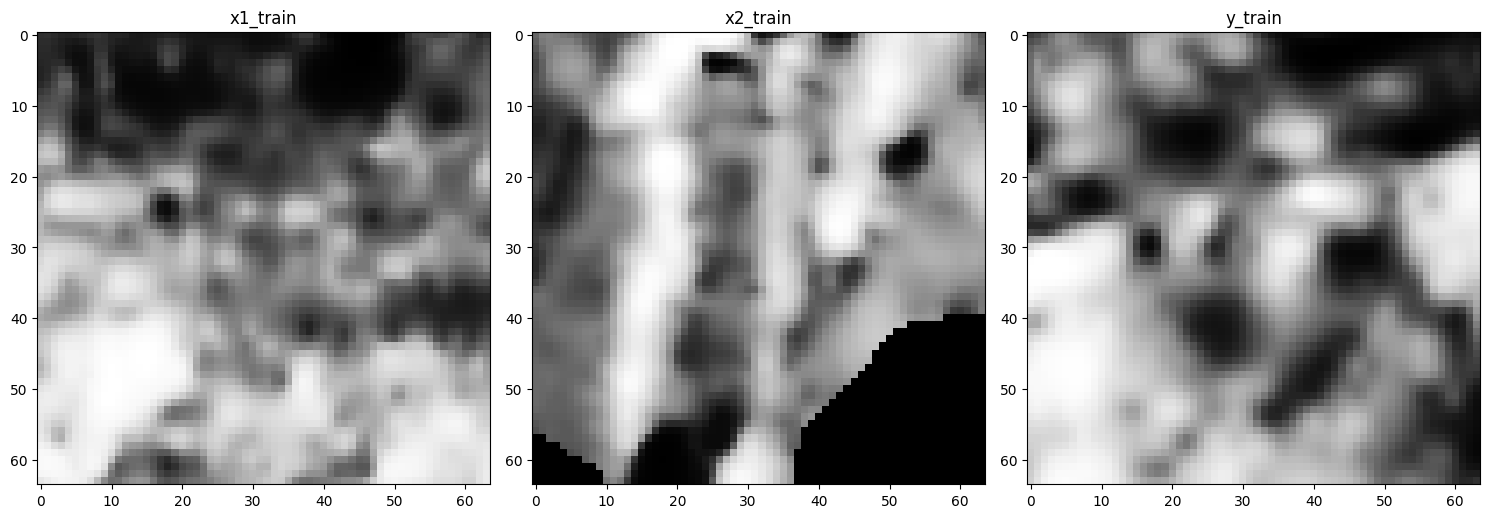

In [14]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 3. Visualize the images side by side

plt.figure(figsize=(15, 5))

j = 1

plt.subplot(1, 3, 1)
plt.imshow(x_train[j], cmap='gray')
plt.title('x1_train')

plt.subplot(1, 3, 2)
plt.imshow(x_train[j+1, :, :], cmap='gray')
plt.title('x2_train')

plt.subplot(1, 3, 3)
plt.imshow(x_train[j+2, :, :], cmap='gray')
plt.title('y_train')

plt.tight_layout()
plt.show()

In [15]:
def build_classifier():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    return model

classifier = build_classifier()

In [16]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
classifier.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = classifier.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=[x_test, y_test])

Epoch 1/50
105/105 [==============================] - 1s 5ms/step - loss: 0.6785 - accuracy: 0.5609 - val_loss: 0.6373 - val_accuracy: 0.6023
Epoch 2/50
105/105 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.6660 - val_loss: 0.5808 - val_accuracy: 0.6591
Epoch 3/50
105/105 [==============================] - 0s 4ms/step - loss: 0.5324 - accuracy: 0.7240 - val_loss: 0.4743 - val_accuracy: 0.7841
Epoch 4/50
105/105 [==============================] - 0s 4ms/step - loss: 0.4688 - accuracy: 0.7641 - val_loss: 0.4355 - val_accuracy: 0.8295
Epoch 5/50
105/105 [==============================] - 0s 4ms/step - loss: 0.4497 - accuracy: 0.7800 - val_loss: 0.4529 - val_accuracy: 0.7670
Epoch 6/50
105/105 [==============================] - 0s 4ms/step - loss: 0.4167 - accuracy: 0.8022 - val_loss: 0.4674 - val_accuracy: 0.7784
Epoch 7/50
105/105 [==============================] - 0s 4ms/step - loss: 0.4025 - accuracy: 0.8066 - val_loss: 0.3961 - val_accuracy: 0.8239
Epoch 

In [25]:
# use the last convolutional layer's output as the feature layer (subject to change)
#feature_extractor = Model(inputs=classifier.input, outputs=classifier.layers[4].output)

# list layer names for selection
for layer in classifier.layers:
    print('Layer name:', layer.name)

print('\n')

for layer in autoencoder.layers: 
    print('Layer name:', layer.name)

Layer name: conv2d_5
Layer name: max_pooling2d_2
Layer name: conv2d_6
Layer name: max_pooling2d_3
Layer name: conv2d_7
Layer name: max_pooling2d_4
Layer name: flatten
Layer name: dense
Layer name: dropout
Layer name: dense_1


Layer name: input_1
Layer name: conv2d
Layer name: max_pooling2d
Layer name: conv2d_1
Layer name: max_pooling2d_1
Layer name: conv2d_2
Layer name: up_sampling2d
Layer name: conv2d_3
Layer name: up_sampling2d_1
Layer name: conv2d_4
